Feel free to contact me if there are any problems or questions.

Vincent Haunberger (vhaunberger@gmail.com)

# Initial data generation

In [47]:
# Used libraries
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_ta as ta 
import warnings
import matplotlib.pyplot as plt


In [48]:
# file must be located in the same directory
df = pd.read_csv("./data/spnasdow_prices.csv")

In [49]:
def make_categories(x):
  if x <= -0.01:
    out = 0
  elif x >= 0.01:
    out = 2
  else: 
    out = 1
  return out

def prepare_targets(df):
  df.loc[:,'logR'] = df.adjClose.apply(np.log).diff()
  df.loc[:,'DiscR'] = (df.adjClose.shift(-1) - df.close) / df.close
  df.loc[:, "belowOne"] = (df.logR <= -0.01) *1
  df.loc[:, "aboveOne"] = (df.logR >= 0.01) *1
  df.loc[:, "abvbelowOne"] = [make_categories(lr) for lr in df.logR]
  df.loc[:, 'increasing'] = (df.logR > 0.00) *1

  df.loc[:, 'logR_target'] = df['logR'].shift(-1)
  df.loc[:, 'belowOne_target'] = df['belowOne'].shift(-1)
  df.loc[:, 'aboveOne_target'] = df['aboveOne'].shift(-1)
  df.loc[:, 'abvbelowOne_target'] = df['abvbelowOne'].shift(-1)
  df.loc[:, 'increasing_target'] = df['increasing'].shift(-1)

  df.dropna(inplace=True)
  df.drop(['logR','belowOne','aboveOne','abvbelowOne','increasing'], axis = 1, inplace = True)

  return df

df_with_targets = df.groupby('symbol', as_index = False, group_keys = False).apply(prepare_targets)  

## Preparing dataset - creating features and target variables

Unfortunately, there is a problem with pandas_ta and this function: after the values are calculated, the process terminates and returns an empty data frame. I was not able to get it to work. With a previous workaround it worked, unfortunately this workaround does not work now either. Since I downloaded the data then I will load it now and continue with it.

In [ ]:
df_with_targets = df_with_targets.sort_values("date")
df_with_targets = df_with_targets.reset_index(drop = True)
df_with_targets.loc[:,'date'] = [datetime.strptime(d,'%Y-%m-%d') for d in df_with_targets.date]
df_with_targets.set_index('date', inplace = True)

warnings.filterwarnings('ignore')

# Function applies all pandas_ta strategies on df
def pandas_ta_strategy(x):
  return x.ta.strategy('all', lookahead = False)

# Does not work ...
#df_Features = df_with_targets.groupby("symbol", as_index = False, group_keys = False).apply(pandas_ta_strategy)

In [51]:
# Loading the data into the notebook

# file must be located in the same directory
df_Features = pd.read_csv("./data/spnasdow_prices_ta.csv", sep=";")
# runtime: 33s

# Set index to date
df_Features = df_Features.sort_values("date")
df_Features = df_Features.reset_index(drop = True)
df_Features.loc[:,'date'] = [datetime.strptime(d,'%Y-%m-%d') for d in df_Features.date]
df_Features.set_index('date', inplace = True)
# runtime: 13s

# A look into the data 

In [52]:
df_Features.head()

,open,high,low,close,adjClose,volume,vwap,symbol,DiscR,logR_target,...,TRIMA_10,TRUERANGE_1,TTM_TRND_6,VIDYA_14,VTXM_14,VWAP_D,WCP,WILLR_14,WMA_10,ZL_EMA_10
date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,30.035765,30.114449,29.456366,29.678112,27.123388,5017282.0,29.74964,A,-0.088064,-0.002172,...,NaN,NaN,-1,NaN,NaN,29.749642,29.731760,NaN,NaN,NaN
2011-01-04,45.540001,45.799999,44.840000,44.990002,39.828274,5230900.0,45.21000,AON,-0.114534,0.000222,...,NaN,NaN,-1,NaN,NaN,45.210000,45.155001,NaN,NaN,NaN
2011-01-04,20.070000,21.010000,20.070000,20.879999,20.636457,4804700.0,20.65333,PWR,-0.014031,-0.002398,...,NaN,NaN,-1,NaN,NaN,20.653333,20.709999,NaN,NaN,NaN
2011-01-04,63.470001,63.560001,61.080002,61.570000,60.672764,909900.0,62.07000,PVH,0.002873,0.017548,...,NaN,NaN,-1,NaN,NaN,62.070001,61.945001,NaN,NaN,NaN
2011-01-04,23.120001,23.120001,22.370001,22.629999,22.629999,637200.0,22.70667,PTC,0.020769,0.020556,...,NaN,NaN,-1,NaN,NaN,22.706667,22.687500,NaN,NaN,NaN


In [53]:
df_Features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255943 entries, 2011-01-04 to 2020-12-30
Columns: 220 entries, open to ZL_EMA_10
dtypes: float64(199), int64(20), object(1)
memory usage: 2.1+ GB


Out dataframe consists of 220 columns with a datetime index ranging from 2011-01-04 to 2020-12-30. There is one column of type object, the ticker symbol. All other columns consist of numerical values of type float or int.

In [54]:
describe = df_Features.describe()
describe["increasing_target"]

count    1.255943e+06
mean     5.242953e-01
std      4.994096e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: increasing_target, dtype: float64

The describe method calculates some key figures like the mean or the standard deviation. Looking at the mean of our target variable "increasing_target" we can already see that 53.43% of the days in our dataframe, the stock price is increasing.

Lets look at some of the features:

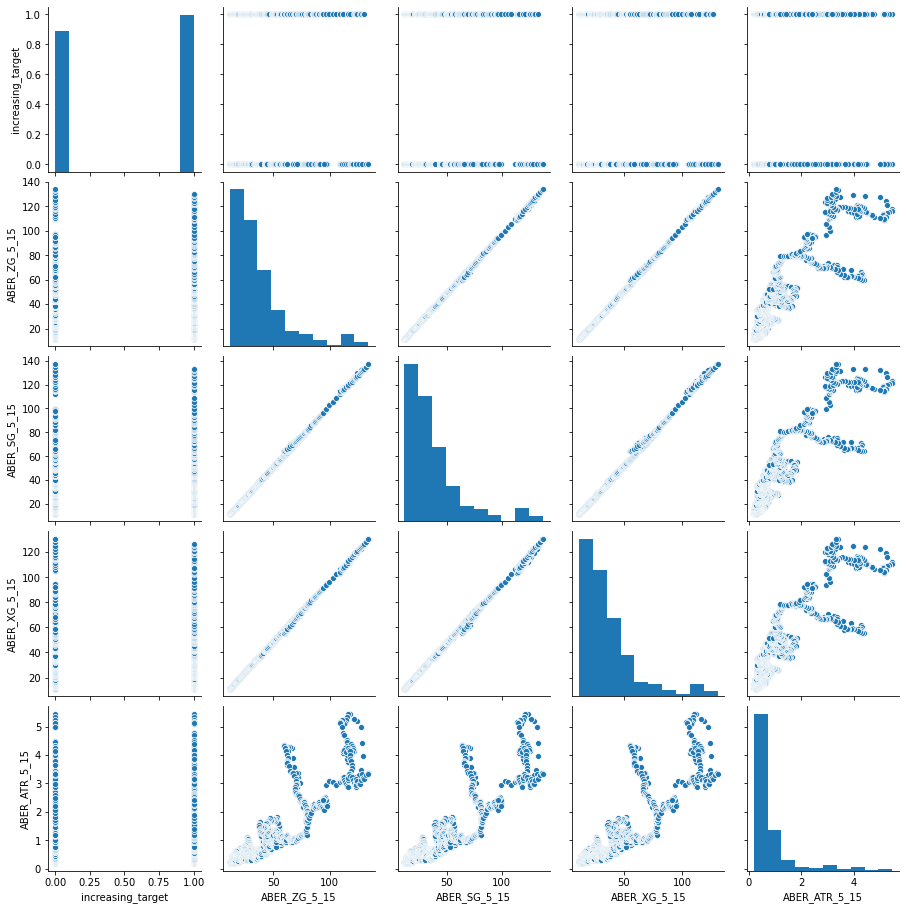

In [55]:
import seaborn as sns

# For vizualization I filtered for one company "AAPL"
df_Features_AAPL = df_Features[df_Features["symbol"] == "AAPL"]


sns.pairplot(df_Features_AAPL.iloc[: , 13:18])

We can see that the "Aberration" indicator positively correlates with its different options. I will have a look at correlations later on again.

Text(0.5, 1.0, 'Aberration indicators over time')

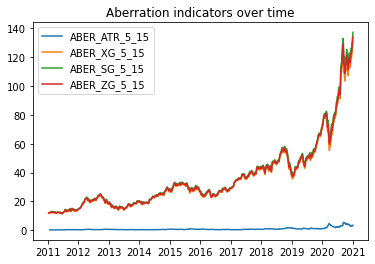

In [56]:
plt.plot(df_Features_AAPL["ABER_ATR_5_15"], label="ABER_ATR_5_15")
plt.plot(df_Features_AAPL["ABER_XG_5_15"], label="ABER_XG_5_15")
plt.plot(df_Features_AAPL["ABER_SG_5_15"], label="ABER_SG_5_15")
plt.plot(df_Features_AAPL["ABER_ZG_5_15"], label="ABER_ZG_5_15")
plt.legend()
plt.title("Aberration indicators over time")

# Data cleaning

## Removing infinity values

Our models can not handle infinity values. These must be removed beforehand

In [57]:
#check if variable has infinite values these need to be dropped
has_inf = []
for col in df_Features.columns:
  if df_Features[col].isin([np.inf,-np.inf]).sum() > 0:
    has_inf.append(col)
  else:
    continue

print("Dropping " + str(len(has_inf)) + " columns, which have infinite values.")
df_Features.drop(has_inf, axis = 1, inplace = True)

Dropping 0 columns, which have infinite values.


## Missing values

In [58]:
print("Number of NaN-values: " + str(df_Features.isna().sum().sum()))

#eliminate all cols with more than 1% of missing data
cols = df_Features.columns[df_Features.isnull().mean()>0.01]
df_Features.drop(cols, axis = 1, inplace = True)

missing_data_col = df_Features.columns[df_Features.isna().any()]
print(str(len(missing_data_col)) + " columns with missing data")
# 94 columns include missing data

Number of NaN-values: 557369
94 columns with missing data


Text(0.5, 1.0, 'Missing values (AAPL)')

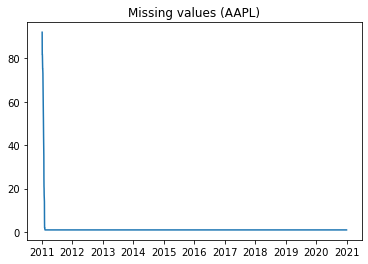

In [74]:
na_mask = df_Features[df_Features["symbol"] == "AAPL"].isna().sum(axis = 1)
plt.plot(na_mask[na_mask > 0])
plt.title("Missing values (AAPL)")
# first 24
# last 12

One can see that missing values are located at the beginning of the dataset (per company). Therefore I removed the first 24 values. The idea is that some indicators are calculated on the basis of rolling mean (of up to 24 days).

I also removed the last 12 for the same reason (just to be sure).

In [75]:
# remove first 24 and last 12 rows per company
# also forward and backfilling missing values

print("Number of missing values (before): " + str(df_Features.isna().sum().sum()))
df_Features = df_Features.groupby("symbol", as_index = False, group_keys = False).apply(lambda group: group.iloc[24:])
df_Features = df_Features.groupby("symbol", as_index = False, group_keys = False).apply(lambda group: group.iloc[:-12])
df_Features = df_Features.groupby("symbol", as_index = False, group_keys = False).apply(lambda x: x.ffill().bfill())
print("Number of missing values (after): " + str(df_Features.isna().sum().sum()))

# runtime: 30s

Number of missing values (before): 557369


Exception ignored in: <function tqdm.__del__ at 0x7fcb29987950>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


Number of missing values (after): 2135


In [76]:
nas_per_column = df_Features.isna().sum()
nas_per_column[nas_per_column > 0]
# VIDYA_14
# AMCR

VIDYA_14    2135
dtype: int64

Still 2135 missing values: the all occur for one indicator (VIDYA_14) and one company (AMCR). Fortunatelly we drop this exact feature due to multicollinearity concerns.

## Multicollinearity

Some features may have a very high correlation with other features and therefore do not add much information for our models. In the following highly correlated features are droped.

In [77]:
# Source: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

# correlation of feature variables (excluding prices & targets)
corrM = df_Features.corr().iloc[14:,14:]

# Create a mask for values above 97% and below 100% (correlation with itself)
mask = (abs(corrM) > 0.97) & (abs(corrM) < 1.0)

# True/False matrix 
high_corr = corrM[mask]

# Columns where corr is over 97% (and below 100%)
col_to_filter_out = ~high_corr[mask].any()

# highly correlated features
high_corr_columns = list(col_to_filter_out[col_to_filter_out==False].index)
print(str(len(high_corr_columns)) + " highly correlated features.")
print(high_corr_columns)
# runtime: 2m 14s

# Note: Feature "VIDYA_14" is included here and therefore dropped. This feature included some missing values.

84 highly correlated features.
['ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15', 'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'ALMA_10_6.0_0.85', 'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'OBV', 'OBV_min_2', 'OBV_max_2', 'OBVe_4', 'OBVe_12', 'AOBV_LR_2', 'AOBV_SR_2', 'ATRr_14', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'CDL_DOJI_10_0.1', 'CDL_DRAGONFLYDOJI', 'CDL_LONGLEGGEDDOJI', 'CDL_TAKURI', 'LDECAY_5', 'DEC_1', 'DEMA_10', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'EMA_10', 'FWMA_10', 'HA_open', 'HA_high', 'HA_low', 'HA_close', 'HILO_13_21', 'HL2', 'HLC3', 'HMA_10', 'HWM', 'HWU', 'HWL', 'HWMA_0.2_0.1_0.1', 'ITS_9', 'INC_1', 'JMA_7_0', 'KAMA_10_2_30', 'KCLe_20_2', 'KCBe_20_2', 'KCUe_20_2', 'LR_14', 'LOGRET_1', 'MIDPOINT_2', 'MIDPRICE_2', 'OHLC4', 'PDIST', 'PCTRET_1', 'PWMA_10', 'QQE_14_5_4.236_RSIMA', 'RMA_10', 'SINWMA_14', 'SMA_10', 'SMI_5_20_5', 'SQZ_ON', 'SQZ_OFF', 'SQZPRO_ON_WIDE', 'SQZPRO_ON_NORMAL', 'SQZPRO_OFF', 'SSF_10_2', 'SUPERT_7_3.0', 'SWMA_10', 'THERMOma_20_2_0.5', 'TOS_STDEVALL_LR', 'TOS_S

<AxesSubplot:>

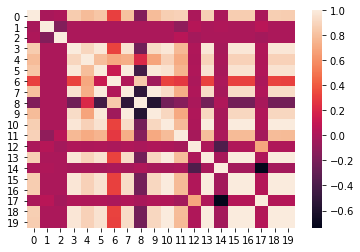

In [78]:
sns.heatmap(corrM.to_numpy()[-20:,-20:])

This heatmap visualized some of the correlations. Very light tiles and very dark tiles indicate high correlation.

In [79]:
# Dropping the above features...

# hca = high-correlation adjusted
df_Features_hca = df_Features[list(df_Features.columns[:14]) + list(high_corr.columns[col_to_filter_out])]
print("Number of columns of df_Features: " + str(len(df_Features.columns)))
print("Number of columns of df_Features_hca: " + str(len(df_Features_hca.columns)))

Number of columns of df_Features: 220
Number of columns of df_Features_hca: 135


## Non-stationary

Using non-stationary time series data in financial models produces unreliable and spurious results and leads to poor understanding and forecasting. The solution to the problem is to transform the time series data so that it becomes stationary. If the non-stationary process is a random walk with or without a drift, it is transformed to stationary process by differencing. On the other hand, if the time series data analyzed exhibits a deterministic trend, the spurious results can be avoided by detrending.

Sometimes the non-stationary series may combine a stochastic and deterministic trend at the same time and to avoid obtaining misleading results both differencing and detrending should be applied, as differencing will remove the trend in the variance and detrending will remove the deterministic trend.

https://www.investopedia.com/articles/trading/07/stationary.asp#:~:text=Using%20non%2Dstationary%20time%20series%20data%20in%20financial%20models%20produces,so%20that%20it%20becomes%20stationary.

The following pipline indentifies non-stationary features per company and transforms them to be stationary. This is done by applying log and diff. 

Note: log() can only be applied on values larger than 0. If the feature includes values smaller than 0, the yeo-johnson transformation is used to archive a similar result.

In [83]:
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PowerTransformer
import time

pt = PowerTransformer(method='yeo-johnson')
df_Features_hca_yj = df_Features_hca.copy()

In [84]:
for company in df_Features_hca_yj.symbol.unique():

    mask = df_Features_hca_yj['symbol'] == company
    
    sub_df = df_Features_hca_yj[mask]
    non_stationary = []
    for col in sub_df.columns[14:]: #the first 14 are obviously either target or basic features
        test_result = adfuller(sub_df.loc[:,col].values)
        if test_result[1] > 0.05:
            non_stationary.append(col)
    print("Found " + str(len(non_stationary)) + " non stationary features for " + company)

    pos, neg = [], []
    for col in sub_df[non_stationary]:
        if any(n < 0 for n in sub_df[col]):
            neg.append(col)
        else:
            pos.append(col)

    if len(neg) > 0:
        df_Features_hca_yj.loc[mask, neg] = pt.fit_transform(df_Features_hca_yj.loc[mask, neg])
    if len(pos) > 0:
        df_Features_hca_yj.loc[mask, pos] = np.log(df_Features_hca_yj.loc[mask, pos])
    if len(non_stationary) > 0:
        df_Features_hca_yj.loc[mask, non_stationary] = df_Features_hca_yj.loc[mask, non_stationary].diff()


# runtime: 194 minutes (3.1h)

Found 7 non stationary features for A
Found 7 non stationary features for AAL
Found 6 non stationary features for AAP
Found 9 non stationary features for AAPL
Found 7 non stationary features for ABBV
Found 7 non stationary features for ABC
Found 10 non stationary features for ABMD
Found 6 non stationary features for ABT
Found 7 non stationary features for ACN
Found 11 non stationary features for ADBE
Found 7 non stationary features for ADI
Found 5 non stationary features for ADM
Found 7 non stationary features for ADP
Found 8 non stationary features for ADSK
Found 7 non stationary features for AEE
Found 7 non stationary features for AEP
Found 6 non stationary features for AES
Found 6 non stationary features for AFL
Found 7 non stationary features for AIG
Found 7 non stationary features for AIZ
Found 8 non stationary features for AJG
Found 6 non stationary features for AKAM
Found 7 non stationary features for ALB
Found 10 non stationary features for ALGN
Found 7 non stationary features 

In [85]:
# replace inf values with "nan"
df_Features_hca_yj.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Number of NaN-values found: " + str(df_Features_hca_yj.isna().sum().sum()))

# backfill and forward fill "nan" values if possible
df_Features_hca_yj = df_Features_hca_yj.groupby("symbol", as_index = False, group_keys = False).apply(lambda x: x.bfill().ffill())
print("Number of NaN-values: " + str(df_Features_hca_yj.isna().sum().sum()))

# dropping remaining row where any value is "nan"
df_Features_hca_yj.dropna(axis=0, how='any', inplace=True)
print("Number of NaN-values: " + str(df_Features_hca_yj.isna().sum().sum()))

Number of NaN-values found: 7734
Number of NaN-values: 738
Number of NaN-values: 0


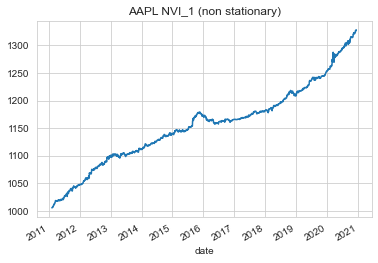

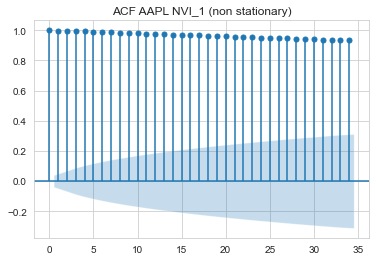

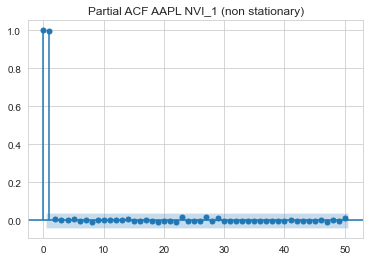

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

symb = "AAPL"
feat = "NVI_1"
symb_df_stat = df_Features_hca_yj[df_Features_hca_yj.symbol == symb]
symb_df_non_stat = df_Features_hca[df_Features_hca.symbol == symb]

symb_df_non_stat[feat].plot()
plt.title(symb + " " + feat + " (non stationary)")
plt.show()

plot_acf(symb_df_non_stat[feat], title = "ACF " + symb + " " + feat + " (non stationary)")
plt.show()

plot_pacf(symb_df_non_stat[feat], lags = 50, title = "Partial ACF " + symb + " " + feat + " (non stationary)")
plt.show()

The above plots show some of the data before it is made stationary: In the first plot we see the actual time series. The data here seem to swing to the positive, indicating non-stationarity. In the ACF plot we see that the value in t=0 is still significantly correlated with the lagged values until well after t=35. The PACF also confirms a lagged dependence. This again indicates non-stationarity. 

p-value adj. dickey fueller test after transformation: 1.323704831858137e-16


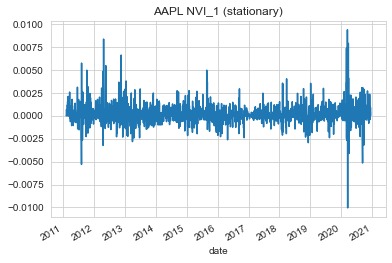

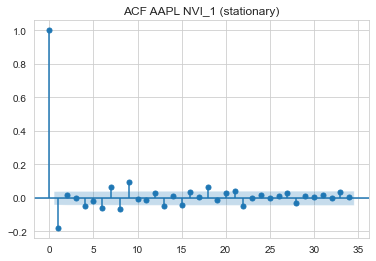

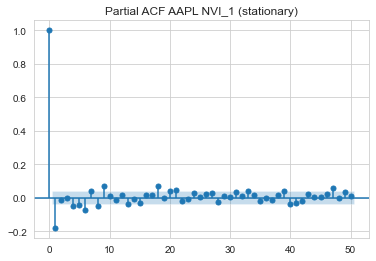

In [111]:
test_result = adfuller(df_Features_hca_yj[df_Features_hca_yj.symbol == symb][feat].values)
print("p-value adj. dickey fueller test after transformation: " + str(test_result[1]))

symb_df_stat[feat].plot()
plt.title(symb + " " + feat + " (stationary)")
plt.show()
plot_acf(symb_df_stat[feat], title = "ACF " + symb + " " + feat + " (stationary)")
plt.show()
plot_pacf(symb_df_stat[feat], lags = 50, title = "Partial ACF " + symb + " " + feat + " (stationary)")
plt.show()

After logarithmizing and differentiating the time series, stationarity can be observed. There seems to be no more significant correlations with any lags.

## Outliers

I did not remove ouliers because of the following reasons:
- Since all features are calculated values there are no measurement errors possible (which should be filtered out)
- If we could predict outlier values, this would add value to our model.

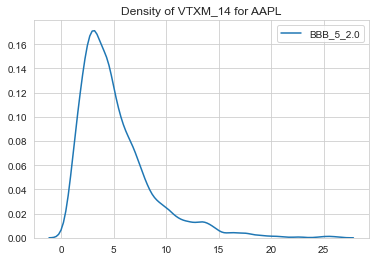

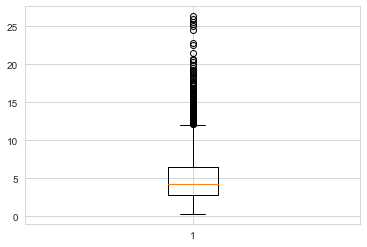

In [87]:
# Boxplot of feature "BBB_5_2.0" for Apple:

feat = "BBB_5_2.0"
sns.set_style('whitegrid')
sns.kdeplot(df_Features_hca_yj[df_Features_hca_yj.symbol == "AAPL"][feat], bw=0.5)
plt.title("Density of VTXM_14 for AAPL")
plt.show()
plt.boxplot(df_Features_hca_yj[df_Features_hca_yj.symbol == "AAPL"][feat])
plt.show()

In [88]:
# Final check of data:
print("Number of NaN-values: " + str(df_Features_hca_yj.isna().sum().sum()))
print("Number of inf-values: " + str(df_Features_hca_yj.isin([np.inf,-np.inf]).sum().sum()))

Number of NaN-values: 0
Number of inf-values: 0


In [101]:
# renaming variable
data = df_Features_hca_yj.copy()
data = data.sort_index()

In [102]:
data.head()

,open,high,low,close,adjClose,volume,vwap,symbol,DiscR,logR_target,...,SUPERTd_7_3.0,THERMO_20_2_0.5,THERMOl_20_2_0.5,THERMOs_20_2_0.5,TOS_STDEVALL_L_1,TOS_STDEVALL_L_2,TOS_STDEVALL_L_3,TTM_TRND_6,VTXM_14,WILLR_14
date,,,,,,,,,,,,,,,,,,,,,
2011-02-08,31.938484,31.981401,31.351931,31.595137,28.875383,5220971.0,31.64282,A,-0.101392,-0.016895,...,1.0,0.329041,1,0,0.004409,0.001626,0.001228,1,0.974985,-12.053513
2011-02-08,5.733333,5.783704,5.712593,5.774815,5.013485,830588.0,5.75704,ROL,-0.136291,-0.005144,...,1.0,0.047408,1,1,0.001915,0.001311,0.001115,1,0.966490,-34.146261
2011-02-08,258.030000,259.990000,257.780000,259.830000,259.830000,218600.0,259.20000,AZO,0.007428,0.007400,...,1.0,1.600000,1,1,0.011360,0.001700,0.001256,1,0.869337,-11.480757
2011-02-08,84.190002,85.339996,83.550003,85.129997,67.385597,1987000.0,84.67333,ROK,-0.203790,0.005856,...,1.0,1.240005,1,1,0.004569,0.002192,0.001340,1,0.754163,-1.728388
2011-02-08,32.500000,32.709999,32.349998,32.639999,28.109533,993400.0,32.56667,RMD,-0.148563,-0.011401,...,-1.0,0.199996,1,0,0.001981,0.001299,0.001115,1,0.931004,-23.718005


# Train, Test and Validation Split

Train, validation and test split:
- Training data from 2011-02-08 to 2018-05-31
- Validation data from 2018-06-01 to 2019-10-01
- Testing data from 2019-10-02 to 2020-12-11

The training data is used to train our models, the validation is used to tune parameters and the test data (holdout data) is used to compare our different models.

**Note:** The testing time period includes the covid price slump which is probably not easily predictable by our models. Thus I expect a drop in accuracy (or other scores) of all models for the testing data in comparison to training and validation data.

In [103]:
split_date = "2018-06-01"
# train: 906,588 rows
df_train = data.loc[data.index < split_date]
# test: 329,825 rows
df_testing = data.loc[data.index >= split_date]


split_date = "2019-10-01"
# validate: 2018-06-01 to 2019-10-01 (172,589 rows)
df_val = df_testing.loc[df_testing.index <= split_date]
# test (holdout): 2019-10-02 to 2020-12-11 (157,236 rows)
df_test = df_testing.loc[df_testing.index > split_date]


split_date = "2019-10-01"
# validate: 2018-06-01 to 2019-10-01 (172,589 rows)
df_val = df_testing.loc[df_testing.index <= split_date]
# test (holdout): 2019-10-02 to 2020-12-11 (157,236 rows)
df_test = df_testing.loc[df_testing.index > split_date]

In [104]:
# feature selection for our models
# target variable is the binary variable 'increasing_target' (thus dropped as a feature)
# feature variables are all (remaining) pandas_ta variables and open, high, low, ...
non_feature = ['symbol', 'DiscR', 'logR_target', 'belowOne_target', 'aboveOne_target', 'abvbelowOne_target','increasing_target']
feature_cols = [x for x in list(data.columns) if x not in non_feature]
target_col = "increasing_target"

# creating actual training and test sets: this data is then used to estimate our models
X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_val = df_val[feature_cols]
y_val = df_val[target_col]

X_test = df_test[feature_cols]
y_test = df_test[target_col]

# Performance Evaluation

In order to evaluate the performance of each model and to be able to compare these, I wrote a function which creates a model report based on the predicted data of a model. The function calculates all relevant performance metrics for classification models and optionally saves those in a .json file.

In [105]:
from sklearn.metrics import classification_report
from sklearn import metrics
import json


def model_report(model, y_pred, y_val, print_out = True, fname=None):
    '''
    Function that documents the model specs and its performance.
    Data is returned as a dictionary and optionally saved as a .json file.
    Args:
        model: model estimator object
        y_pred: predicted target values
        y_val: validation target values
        print_out (bool): if true, acc, pred, recall and f1 score are printed out
        fname (str): Filename of output file; If not None, json file containing model report is created
    '''

    output_dict = {}
    output_dict["model"] = type(model).__name__
    output_dict["model_config"] = model.get_params()
    output_dict["model_performance"] = classification_report(y_val, y_pred, output_dict = True)
    output_dict["model_performance"]["confusion_matrix"] = metrics.confusion_matrix(y_val, y_pred).tolist()

    if print_out:
        print("Accuracy: " + str(output_dict["model_performance"]['accuracy']))
        print("Precision: " + str(output_dict["model_performance"]['1.0']["precision"]))
        print("Recall: " + str(output_dict["model_performance"]['1.0']["recall"]))
        print("F1-Score: " + str(output_dict["model_performance"]['1.0']["f1-score"]))

    if fname != None:
        out_file = open(str(fname), "w")
        json.dump(output_dict, out_file, indent = 6) 
        out_file.close()
        print("Created .json file '" + str(fname) + "'")

    return output_dict

# Scaling

In the next step the data is scaled to the range 0 to 1; This is necessary for many machine learning models. I chose the MinMaxScaler because it resulted in better model performance than e.g. the StandardScaler.

In [106]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Benchmark: logistic regression

The benchmark model is a simple logistic regression model. I tried out a few different parameters and the best set was:
- solver: newton-cg
- penalty: l2
- class_weight: balanced

**Note:** Since we have time series data, we can not use the solvers ‘sag’, ‘saga’ or ‘liblinear’, because they shuffle the data.  

In [123]:
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg1 = LogisticRegression(solver="newton-cg", penalty="l2", class_weight="balanced", max_iter=200) 

# fit the model with data
logreg1.fit(X_train,y_train)

# validation (used for tunig the parameters; not included in this notebook to reduce lenght)
y_pred1 = logreg1.predict(X_val)

# model performance of logistic regression (on validation data)
print("MODEL logreg1")
logreg1_report = model_report(logreg1, y_pred1, y_val, print_out = True)

# runtime: 2m

MODEL logreg1
Accuracy: 0.6444501097984229
Precision: 0.6760136238510708
Recall: 0.6330944682338547
F1-Score: 0.6538504930165391


In [124]:
# Now lets look into the feature importance of our logistic regression:

# calc feature importance
feature_importance = logreg1.coef_ / np.sum(np.abs(logreg1.coef_))

# create dataframe containing the feature importances
ft_importance = pd.DataFrame(feature_cols, columns = ["feature"])
ft_importance["coef"] = logreg1.coef_.T
ft_importance["feature importance"] = feature_importance.T
ft_importance["feature importance (%)"] = ft_importance.apply(lambda x: round(x["feature importance"]*100, 4), axis = 1)

# sort from highest to lowest
ft_importance.sort_values(by='feature importance (%)', ascending=False, key=lambda x: abs(x), inplace=True)
ft_importance.drop(["feature importance"], axis = 1)

# show top 12
ft_importance.head(n=12)

,feature,coef,feature importance,feature importance (%)
80,DPO_20,-104.722473,-0.508638,-50.8638
84,BULLP_13,16.733947,0.081277,8.1277
85,BEARP_13,16.426978,0.079786,7.9786
108,SLOPE_1,12.246369,0.059481,5.9481
92,MOM_10,7.629379,0.037056,3.7056
109,SQZ_20_2.0_20_1.5,-4.708881,-0.022871,-2.2871
111,SQZPRO_20_2.0_20_2_1.5_1,-4.708881,-0.022871,-2.2871
102,QS_10,4.141972,0.020118,2.0118
15,BBP_5_2.0,3.744093,0.018185,1.8185
81,EFI_13,1.873128,0.009098,0.9098


It is clear, that the feature 'DPO_20' has the largest impact with over 50%. Looking into that feature I find that there exists a issue with this feature that leaks future data for machine learning models. This means this feature already shows data from the future, which is why it is so good at predicting. Since this is not possible on new data, I drop this feature and reestimate the model:

(future data leak issue source: https://github.com/twopirllc/pandas-ta/issues/60)


**Reestimating model without DPO_20:**

In [125]:
# reestimate without DPO_20
#feature_cols = list(data.columns[0:7]) + list(data.columns[13:])
non_feature = ['DPO_20', 'increasing_target', 'symbol', 'DiscR', 'logR_target', 'belowOne_target', 'aboveOne_target', 'abvbelowOne_target']
feature_cols = [x for x in list(data.columns) if x not in non_feature]
target_col = "increasing_target"

# data
X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_val = df_val[feature_cols]
y_val = df_val[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]

# scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# same configuration
logreg2 = LogisticRegression(solver="newton-cg", penalty="l2", class_weight="balanced", max_iter=200) 
# fit the model with data
logreg2.fit(X_train,y_train)
# validation
y_pred2 = logreg2.predict(X_val)

# model performance of logistic regression (on validation data)
print("MODEL logreg2")
logreg2_report = model_report(logreg2, y_pred2, y_val)

MODEL logreg2
Accuracy: 0.5076800954869661
Precision: 0.5356387880101903
Recall: 0.5397404526784934
F1-Score: 0.5376817981489643


In [126]:
feature_importance = logreg2.coef_ / np.sum(np.abs(logreg2.coef_))

ft_importance_logreg = pd.DataFrame(feature_cols, columns = ["feature"])
ft_importance_logreg["coef"] = logreg2.coef_.T
ft_importance_logreg["feature importance"] = feature_importance.T
ft_importance_logreg["feature importance (%)"] = ft_importance_logreg.apply(lambda x: round(x["feature importance"]*100, 4), axis = 1)

ft_importance_logreg.sort_values(by='feature importance (%)', ascending=False, key=lambda x: abs(x), inplace=True)
ft_importance_logreg.drop(["feature importance"], axis = 1)

ft_importance_logreg.head(n=12)

,feature,coef,feature importance,feature importance (%)
15,BBP_5_2.0,3.839110,0.112393,11.2393
123,TOS_STDEVALL_L_3,2.290688,0.067062,6.7062
91,MOM_10,-1.953143,-0.057180,-5.7180
77,CG_10,-1.564669,-0.045807,-4.5807
81,ENTP_10,1.486291,0.043512,4.3512
122,TOS_STDEVALL_L_2,1.222390,0.035786,3.5786
83,BULLP_13,1.144490,0.033506,3.3506
107,SLOPE_1,1.003985,0.029392,2.9392
118,THERMO_20_2_0.5,-0.932379,-0.027296,-2.7296
76,CFO_9,-0.814493,-0.023845,-2.3845


Now the importance of the top 12 feature seems more distributed with BBP_5_2.0 beeing the most important feature.

- BBP_5_2.0: Bollinger Band Percent quantifies a symbol's price relative to the upper and lower Bollinger Band (5 refers to the short period, 2 refers to the long period)
- TOS_STDEVALL_L_3: A port of TD Ameritrade's Think or Swim Standard Deviation All indicator which returns the standard deviation of data for the entire plot or for the interval of the last bars defined by the length parameter.
- MOM_10: Momentum is an indicator used to measure a security's speed (or strength) of movement. Or simply the change in price. (10 refers to the period)

**Plotting the ROC-curve:**

It becomes clear, that the logistic regression model has low predictive power, the blue line is almost equal to the red line (which indicates a model which choses randomly)

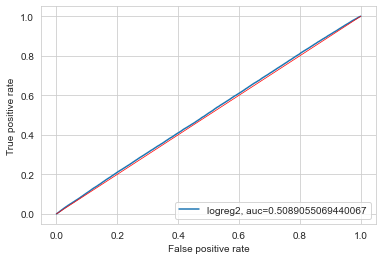

In [127]:
y_pred_proba = logreg2.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="logreg2, auc="+str(auc))
plt.plot([0,1],[0,1], color = "red", lw=0.7)
plt.legend(loc=4)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [129]:
logreg2_report["model_performance"]

{'0.0': {'precision': 0.47558000597431044,
  'recall': 0.4714664692454809,
  'f1-score': 0.4735143039488441,
  'support': 81045},
 '1.0': {'precision': 0.5356387880101903,
  'recall': 0.5397404526784934,
  'f1-score': 0.5376817981489643,
  'support': 91544},
 'accuracy': 0.5076800954869661,
 'macro avg': {'precision': 0.5056093969922504,
  'recall': 0.5056034609619872,
  'f1-score': 0.5055980510489042,
  'support': 172589},
 'weighted avg': {'precision': 0.5074361563818832,
  'recall': 0.5076800954869661,
  'f1-score': 0.5075497818127624,
  'support': 172589},
 'confusion_matrix': [[38210, 42835], [42134, 49410]]}

**Lets look at the confusion matrix:**

Recall the following metrics of our logistic regression:
- Accuracy: 0.5076
- Precision: 0.5356
- Recall: 0.5397
- F1-Score: 0.5376

In the following I try to optimize for accuracy, because I want my model to predict both classes as good as possible. The confusion matrix below indicates that our model is not yet able to really distinguish the classes. 

(0.0, 2.0)

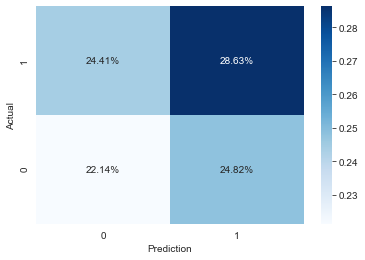

In [133]:
cm = logreg2_report["model_performance"]["confusion_matrix"]
#fx = sn.heatmap(cm, annot=True, cmap='Blues', fmt='d')
fx = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
fx.set(xlabel='Prediction', ylabel='Actual')
fx.set_ylim([0,2])

In [134]:
# validation on holdout data
logreg_y_pred = logreg2.predict(X_test)
logreg_report = model_report(logreg2, logreg_y_pred, y_test, print_out=True, fname="benchmark_logreg.json")

Accuracy: 0.5168409270141698
Precision: 0.5457006574706716
Recall: 0.5096315916205153
F1-Score: 0.5270497416422835
Created .json file 'benchmark_logreg.json'


# Data preparation for GridSearchCV

Now we tune the parameters using cross validation. Therefore we do not need a validation set.

In [248]:
# no validation set this time
split_date = "2019-10-01"
df_train = data.loc[data.index < split_date]
df_test = data.loc[data.index >= split_date]


# again, features are selected and data is scaled
non_feature = ['DPO_20', 'increasing_target', 'symbol', 'DiscR', 'logR_target', 'belowOne_target', 'aboveOne_target', 'abvbelowOne_target']
feature_cols = [x for x in list(data.columns) if x not in non_feature]
target_col = "increasing_target"

X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# create dataframes containing train & test data used for cross-validation
train_data = pd.DataFrame(np.concatenate((np.array([y_train]).T, X_train), axis=1), columns = [target_col] + feature_cols, index=df_train.index)
test_data = pd.DataFrame(np.concatenate((np.array([y_test]).T, X_test), axis=1), columns = [target_col] + feature_cols, index=df_test.index)

# First we need splits for the Gridsearch
# Before we use Gridsearch we need to reset our index back to normal
train_data.reset_index(inplace=True, drop = False)
train_data.sort_values(by="date",inplace = True)
train_data.reset_index(inplace=True, drop = True)

In [440]:
sum(y_test["increasing_target"]) / len(y_test["increasing_target"])

0.5267251543542477

In [136]:
from sklearn.model_selection import TimeSeriesSplit

# Our Grid Search algorithms use cross validation to test the model on 3 different datasets, meaning 3 different time periods

# gap = 1000 ensures that testing and validation data dates do not intersect (>500 company-prices per day)
time_series_split = TimeSeriesSplit(n_splits = 3, gap = 1000, test_size = 150000)

for i, (t_split_idx, v_split_idx) in enumerate(time_series_split.split(X_train)):
  print('-'*100)
  print(f'Training data for split number {i +1} starts at: {train_data.loc[t_split_idx[0]].date} and ends at: {train_data.loc[t_split_idx[-1]].date}')
  print(f'Validation data for split number {i +1} starts at: {train_data.loc[v_split_idx[0]].date} and ends at: {train_data.loc[v_split_idx[-1]].date}')

----------------------------------------------------------------------------------------------------
Training data for split number 1 starts at: 2011-02-08 00:00:00 and ends at: 2016-03-28 00:00:00
Validation data for split number 1 starts at: 2016-03-30 00:00:00 and ends at: 2017-06-01 00:00:00
----------------------------------------------------------------------------------------------------
Training data for split number 2 starts at: 2011-02-08 00:00:00 and ends at: 2017-05-30 00:00:00
Validation data for split number 2 starts at: 2017-06-01 00:00:00 and ends at: 2018-08-02 00:00:00
----------------------------------------------------------------------------------------------------
Training data for split number 3 starts at: 2011-02-08 00:00:00 and ends at: 2018-07-31 00:00:00
Validation data for split number 3 starts at: 2018-08-02 00:00:00 and ends at: 2019-09-30 00:00:00


# Note to my GridSearch strategy

Since GridSearch can take a very long time to process (exponential increase in time with increasing parameters), I started with a small parameter set and searched for a optimal combination, which should be available in reasonable time (stage 1).

Then I analyzed the effect of each parameter and started another GridSearch (stage 2) based on this analysis. This step could be repeated more than twice to receive even better results.

# DecisionTreeClassifier

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


# Definition of stage 1 parameters for the DecisionTree: there are already 864 combinations
parameters_dt_stage1={
            "splitter":["best","random"],
            "max_depth" : [3,5,9,12],
            "min_samples_leaf":[1,2,4,6,8,10],
            "min_weight_fraction_leaf":[0.1,0.3,0.5],
            "max_leaf_nodes":[None,10,30,50,70,90]
}

dt_classifier = DecisionTreeClassifier()

# GridSearch setup: parameters defined above; optimizing for the metric accuracy; cross validation defined above
gridSearch_DT_s1 = GridSearchCV(dt_classifier, param_grid=parameters_dt_stage1, scoring='accuracy', cv=time_series_split, verbose=3)

start = datetime.now()
gridSearch_DT_s1.fit(X_train, y_train)
end = datetime.now()
print(f'It took: {end - start}')

# Fitting 3 folds for each of 864 candidates, totalling 2592 fits
# runtime: 241m (~4h)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.527 total time=  13.0s
[CV 2/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.529 total time=  15.8s
[CV 3/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.523 total time=  19.2s
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.529 total time=   3.3s
[CV 2/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.528 total time=   4.2s
[CV 3/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.518 total time=   5.4s
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=1,

The Grid Search ran for allmost 4 hours and fitted 2592 models on 864 different parameter sets. The optimal parameters can be seen below. In the next step I look into the data and analyze the effect of each parameter on our metric of interest precision. This should provide the info, to further tune the hyperparameters of our model.

In [144]:
# Grid Search stage 1 results:
GridSearch_DT_s1_RESULTS = gridSearch_DT_s1.cv_results_
GridSearch_DT_s1_ESTIMATOR = gridSearch_DT_s1.best_estimator_
GridSearch_DT_s1_INDEX = gridSearch_DT_s1.best_index_

print("Best accuracy score (DT stage 1): " + str(gridSearch_DT_s1.best_score_))
print("Optimal parameters: " + str(gridSearch_DT_s1.best_params_))


dt_s1_y_pred = GridSearch_DT_s1_ESTIMATOR.predict(X_test)
dt_s1_model_report = model_report(GridSearch_DT_s1_ESTIMATOR, dt_s1_y_pred, y_test, print_out=True, fname="gridSeach_DT_stage1.json")

# note: accuracy differs here, because the model report is created on the holdout-data
# Since the holdout timespan covers the covid-slump, the model doesn't perform as well

Best accuracy score (DT stage 1): 0.5320133333333333
Optimal parameters: {'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
Accuracy: 0.5241198321437174
Precision: 0.5302476072675713
Recall: 0.8461001528407929
F1-Score: 0.6519320110162183
Created .json file 'gridSeach_DT_stage1.json'


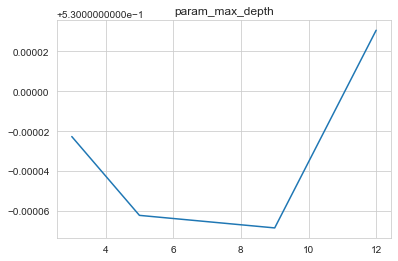

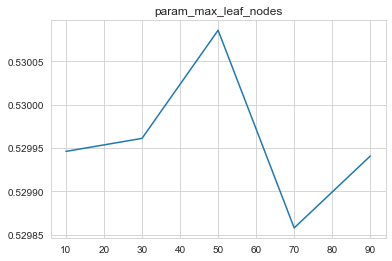

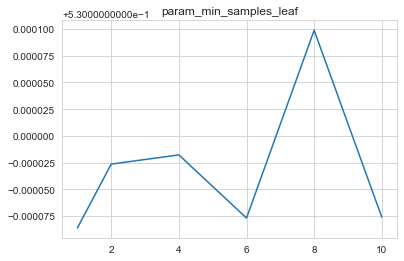

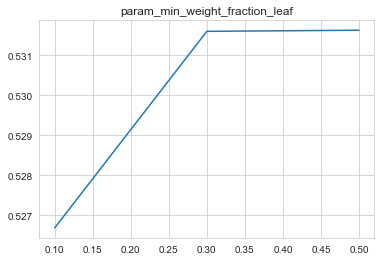

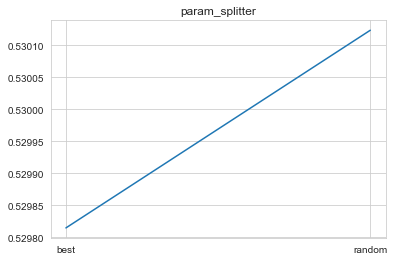

In [145]:
# lets analyze the results:
fits_dt_s1_df = pd.DataFrame(gridSearch_DT_s1.cv_results_)
fits_dt_s1_df = fits_dt_s1_df.astype({"param_max_depth": float, "param_max_leaf_nodes": float, "param_min_samples_leaf": float, "param_min_weight_fraction_leaf": float}, errors='raise') 


plt.plot(fits_dt_s1_df.groupby(["param_max_depth"]).mean()[["mean_test_score"]])
plt.title("param_max_depth")
plt.show()

plt.plot(fits_dt_s1_df.groupby(["param_max_leaf_nodes"]).mean()[["mean_test_score"]])
plt.title("param_max_leaf_nodes")
plt.show()

plt.plot(fits_dt_s1_df.groupby(["param_min_samples_leaf"]).mean()[["mean_test_score"]])
plt.title("param_min_samples_leaf")
plt.show()

plt.plot(fits_dt_s1_df.groupby(["param_min_weight_fraction_leaf"]).mean()[["mean_test_score"]])
plt.title("param_min_weight_fraction_leaf")
plt.show()

plt.plot(fits_dt_s1_df.groupby(["param_splitter"]).mean()[["mean_test_score"]])
plt.title("param_splitter")
plt.show()

The above plots indicate how the parameters affect the test score. Unfortunately a regression analysis did not reveal any significant (linear) correlations of the parameters. In the following to further try to optimize performance I created a second parameter set, and included parameters near the optimal parameter values of stage 1.

**Note:** I have chosen the parameter max_depth not lower than 3, so that I don't get a too small tree, where only 1 feature is important.
The basis for this is that max_depth does not have a huge impact on performance.


In [148]:
# Definition of stage 2 parameters for the DecisionTree:
# Optimal parameters: {'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
parameters_dt_stage2={
            "splitter":["random"],
            "max_depth" : [3,4,5,6,9,12],
            "min_samples_leaf":[6,8,10],
            "min_weight_fraction_leaf":[0.05, 0.1, 0.15],
            "max_leaf_nodes":[None]
}

dt_classifier = DecisionTreeClassifier()

# GridSearch setup: parameters defined above; optimizing for the metric accuracy; cross validation defined above
gridSearch_DT_s2 = GridSearchCV(dt_classifier, param_grid=parameters_dt_stage2, scoring='accuracy', cv=time_series_split, verbose=3)

start = datetime.now()
gridSearch_DT_s2.fit(X_train, y_train)
end = datetime.now()
print(f'It took: {end - start}')

# Fitting 3 folds for each of 360 candidates, totalling 1080 fits
# runtime: 60m (~1h)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.05, splitter=random;, score=0.527 total time=   3.9s
[CV 2/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.05, splitter=random;, score=0.523 total time=   3.6s
[CV 3/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.05, splitter=random;, score=0.531 total time=   4.4s
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=0.532 total time=   2.6s
[CV 2/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=0.527 total time=   3.3s
[CV 3/3] END max_depth=3, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random;, score=0.523 total time=   4.4s
[CV 1/3] END max_depth=3, max_leaf_nodes=None, min_samples_

In [207]:
# Grid Search stage 2 results:
GridSearch_DT_s2_RESULTS = gridSearch_DT_s2.cv_results_
GridSearch_DT_s2_ESTIMATOR = gridSearch_DT_s2.best_estimator_

# model performance report
dt_s2_y_pred = GridSearch_DT_s2_ESTIMATOR.predict(X_test)
dt_s2_model_report = model_report(GridSearch_DT_s2_ESTIMATOR, dt_s2_y_pred, y_test, print_out=True, fname="gridSeach_DT_stage2.json")

Accuracy: 0.5259010865017686
Precision: 0.5277143505721802
Recall: 0.9512233280781774
F1-Score: 0.6788307689665094
Created .json file 'gridSeach_DT_stage2.json'


In [209]:
print("_"*50)
print("Results Stage 1 Estimator")
print(gridSearch_DT_s1.best_params_)
print("Accuracy: " + str(dt_s1_model_report["model_performance"]["accuracy"]))
print(dt_s1_model_report["model_performance"]["1.0"])

print("_"*50)
print("Results Stage 2 Estimator")
print(gridSearch_DT_s2.best_params_)
print("Accuracy: " + str(dt_s2_model_report["model_performance"]["accuracy"]))
print(dt_s2_model_report["model_performance"]["1.0"])

__________________________________________________
Results Stage 1 Estimator
{'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
Accuracy: 0.5241198321437174
{'precision': 0.5302476072675713, 'recall': 0.8461001528407929, 'f1-score': 0.6519320110162183, 'support': 83093}
__________________________________________________
Results Stage 2 Estimator
{'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.05, 'splitter': 'random'}
Accuracy: 0.5259010865017686
{'precision': 0.5277143505721802, 'recall': 0.9512233280781774, 'f1-score': 0.6788307689665094, 'support': 83093}


Stage 2 did slightly improve the accuracy on the holdout data set.

(0.0, 2.0)

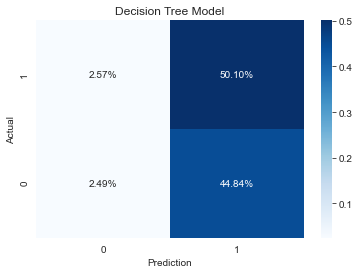

In [151]:
# Confusion matrix of decision tree model:
cm_dt = dt_s2_model_report["model_performance"]["confusion_matrix"]
#fx = sn.heatmap(cm, annot=True, cmap='Blues', fmt='d')
fx = sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, fmt='.2%', cmap='Blues')
fx.set(xlabel='Prediction', ylabel='Actual', title="Decision Tree Model")
fx.set_ylim([0,2])

**Looking into the feature importance of our model features:**

In [162]:
#fi_gs_dt = sorted(list(GridSearch_DT_s2_ESTIMATOR.feature_importances_), reverse=True)
fi_gs_dt = GridSearch_DT_s2_ESTIMATOR.feature_importances_
feature_importances_dt = sorted([(feature_cols[i], fi_gs_dt[i]) for i in list(np.where(fi_gs_dt > 0)[0])], key=lambda x: x[1], reverse=True)
feature_importances_dt

for i in feature_importances_dt:
    print("Feature importance of feature '" + str(i[0]) + "' = " + str(round(i[1]*100, 4)) + "%")

Feature importance of feature 'TTM_TRND_6' = 43.2598%
Feature importance of feature 'AROOND_14' = 14.0531%
Feature importance of feature 'PVR' = 11.9059%
Feature importance of feature 'CMO_14' = 10.8345%
Feature importance of feature 'BOP' = 8.0552%
Feature importance of feature 'FISHERTs_9_1' = 4.2046%
Feature importance of feature 'WILLR_14' = 2.3757%
Feature importance of feature 'THERMOs_20_2_0.5' = 2.3453%
Feature importance of feature 'RSI_14' = 1.0712%
Feature importance of feature 'TOS_STDEVALL_L_3' = 1.0102%
Feature importance of feature 'SUPERTd_7_3.0' = 0.8844%


**3 Most important features:**
- [trend] TTM_TRND_6: TTM Trend (length=6) - It checks if the price is above or under the average price of the previous 5 bars

- [trend] AROOND_14: Indicator: Aroon & Aroon Oscillator (down) - Aroon attempts to identify if a security is trending and how strong.

- [volume] PVR: Price Volume Rank - The basic interpretation is to buy when the PV Rank is below
2.5 and sell when it is above 2.5. PVR can take values between 1 and 4. Note that the data is scaled to the range 0 to 1.


The graph below visualizes the decision tree further:

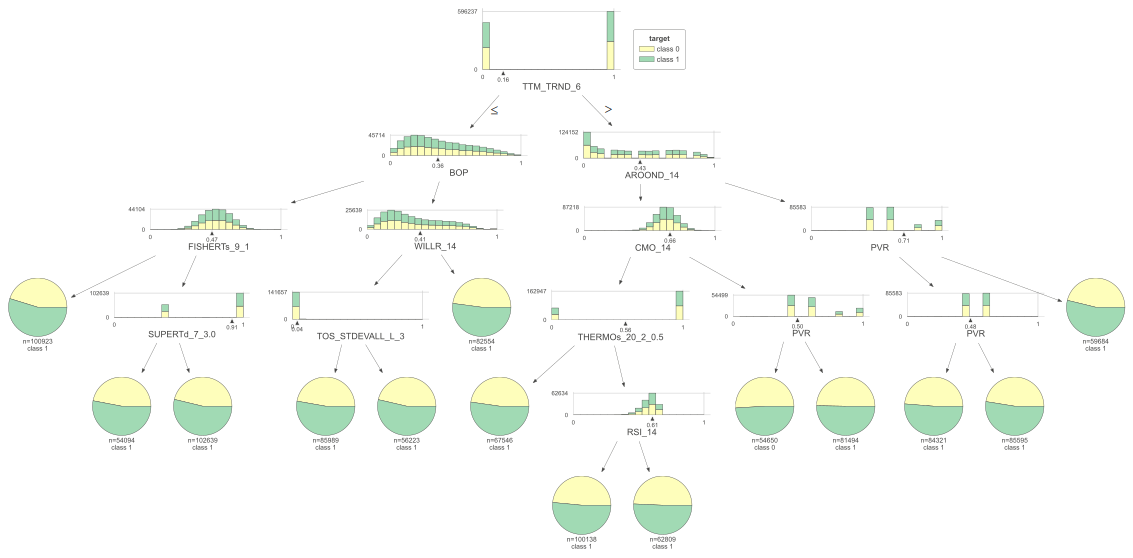

In [163]:
from dtreeviz.trees import dtreeviz

dt_s2_viz = dtreeviz(GridSearch_DT_s2_ESTIMATOR, X_train, y_train, target_name="target", feature_names=feature_cols)
dt_s2_viz

# If you get the error "ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH", you may need to brew install graphviz (mac)
# with "brew install graphviz" (details: https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft)

# Gradient Boosting

In [149]:
from sklearn.ensemble import GradientBoostingClassifier


# stage 1 parameters for gradient boosting
parameters_gb_stage1 = {
    'warm_start': [True],
    'n_estimators': [5, 10, 15],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.001,0.1,1],
}


gb_classifier = GradientBoostingClassifier()
gridSearch_GB_s1 = GridSearchCV(gb_classifier, param_grid = parameters_gb_stage1, cv = time_series_split, scoring = 'accuracy', verbose=3)

start = datetime.now()
gridSearch_GB_s1.fit(X_train, y_train)
end = datetime.now()
print(f'It took: {end - start}')

# Fitting 3 folds for each of 27 candidates, totalling 81 fits
# runtime: 388m (~6.5h)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=5, warm_start=True;, score=0.531 total time=  58.3s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=5, warm_start=True;, score=0.533 total time= 1.2min
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=5, warm_start=True;, score=0.531 total time= 1.5min
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=10, warm_start=True;, score=0.531 total time= 1.9min
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=10, warm_start=True;, score=0.533 total time= 2.4min
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=10, warm_start=True;, score=0.531 total time= 2.9min
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=15, warm_start=True;, score=0.531 total time= 2.9min
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=15, warm_start=True;, score=0.533 total time= 3.6min
[CV 3/3] END learning_rate=0.001, max_

In [152]:
# Tuning evaluation: stage 1
GridSearch_GB_ESTIMATOR_s1 = gridSearch_GB_s1.best_estimator_
GridSearch_GB_INDEX_s1 = gridSearch_GB_s1.best_index_

print(gridSearch_GB_s1.best_score_)
print(gridSearch_GB_s1.best_params_)


gb_s1_y_pred = GridSearch_GB_ESTIMATOR_s1.predict(X_test)
gb_s1_model_report = model_report(GridSearch_GB_ESTIMATOR_s1, gb_s1_y_pred, y_test, print_out=True, fname="gridSeach_GB_stage1.json")

0.5331466666666667
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'warm_start': True}
Accuracy: 0.5267948831725344
Precision: 0.5267975598763434
Recall: 0.9987363556496938
F1-Score: 0.6897675230440602
Created .json file 'gridSeach_GB_stage1.json'


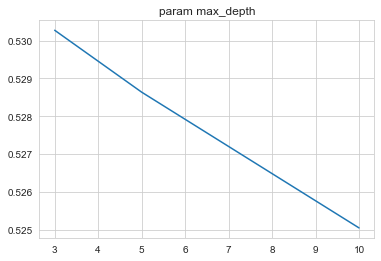

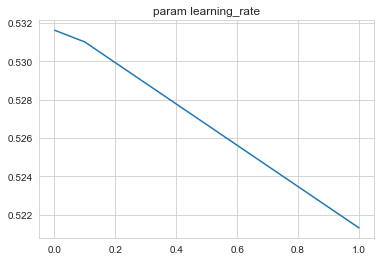

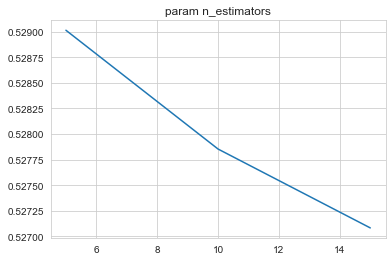

In [153]:
# lets analyze the results:

fits_s1_df = pd.DataFrame(gridSearch_GB_s1.cv_results_)
fits_s1_df = fits_s1_df.astype({"param_learning_rate": float, "param_max_depth": float, "param_n_estimators": float}, errors='raise')

plt.plot(fits_s1_df.groupby(["param_max_depth"]).mean()[["mean_test_score"]])
plt.title("param max_depth")
plt.show()

plt.plot(fits_s1_df.groupby(["param_learning_rate"]).mean()[["mean_test_score"]])
plt.title("param learning_rate")
plt.show()

plt.plot(fits_s1_df.groupby(["param_n_estimators"]).mean()[["mean_test_score"]])
plt.title("param n_estimators")
plt.show()

Looking at the graphical analysis we find that all parameters should be chosen as low as possible, but the optimal grid search results don't reflect this finding.

There may be dependencies between the parameters, which can not be identified in the above graphical analysis. Below I conducted a regression analysis on the data trying to find these dependences.

In [160]:
from pandas import DataFrame
import statsmodels.api as sm
import statsmodels.formula.api as smf

interactions_string = " + param_max_depth:param_learning_rate + param_max_depth:param_n_estimators + param_learning_rate:param_n_estimators "
reg_obj = smf.ols(formula='mean_test_score ~ param_max_depth + param_learning_rate + param_n_estimators' + interactions_string, data=fits_s1_df).fit().summary()
print(reg_obj)

                            OLS Regression Results                            
Dep. Variable:        mean_test_score   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     138.2
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           3.32e-15
Time:                        21:54:01   Log-Likelihood:                 151.95
No. Observations:                  27   AIC:                            -289.9
Df Residuals:                      20   BIC:                            -280.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

The output above indicates that this regression model can in fact explain the variance in the data ($ adj. \ R^2 = 96.9 \%$).

The following parameters are statistically significant (significance level = 5%):
- The interaction of param_max_depth and param_learning_rate: negative synergy effect of max_depth on the learning_rate;
- The interaction of param_learning_rate and param_n_estimators: negative synergy effect of learning_rate on n_estimators

These results explain why the optimal model did not just chose the parameters as low as possible as the graphical analysis indicated. There seem to be tradeoffs between the mentioned parameters.


For the next stage I chose parameters near the optimal parameters of stage 1.

In [156]:
# Stage 2
# recall the optimal parameters for stage 1: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'warm_start': True}
parameters_gb_stage2 = {
    'warm_start': [True],
    'n_estimators': [9, 10, 11],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1, 0.15],
}

gb_classifier = GradientBoostingClassifier()
gridSearch_GB_s2 = GridSearchCV(gb_classifier, param_grid = parameters_gb_stage2, cv = time_series_split, scoring = 'accuracy', verbose=3)

start = datetime.now()
gridSearch_GB_s2.fit(X_train, y_train)
end = datetime.now()
print(f'It took: {end - start}')

# Fitting 3 folds for each of 16 candidates, totalling 48 fits
# runtime: 155m (~ 2,5h)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=9, warm_start=True;, score=0.533 total time= 1.7min
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=9, warm_start=True;, score=0.535 total time= 2.2min
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=9, warm_start=True;, score=0.531 total time= 2.6min
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=10, warm_start=True;, score=0.533 total time= 1.9min
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=10, warm_start=True;, score=0.535 total time= 2.4min
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=10, warm_start=True;, score=0.531 total time= 2.9min
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=11, warm_start=True;, score=0.533 total time= 2.1min
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=11, warm_start=True;, score=0.535 total time= 2.7min
[CV 3/3] END learning_rate=0.05, max_depth=3, 

In [211]:
# Tuning evaluaion: stage 2
GridSearch_GB_ESTIMATOR_s2 = gridSearch_GB_s2.best_estimator_
GridSearch_GB_INDEX_s2 = gridSearch_GB_s2.best_index_

gb_s2_y_pred = GridSearch_GB_ESTIMATOR_s2.predict(X_test)
gb_s2_model_report = model_report(GridSearch_GB_ESTIMATOR_s2, gb_s2_y_pred, y_test, print_out=True, fname="gridSeach_GB_stage2.json")

# note: accuracy differs, because the model report is created on the holdout-data
# Since the holdout timespan covers the covid-slump, the model will likly not perform as well

Accuracy: 0.5267948831725344
Precision: 0.5267975598763434
Recall: 0.9987363556496938
F1-Score: 0.6897675230440602
Created .json file 'gridSeach_GB_stage2.json'


In [210]:
print("_"*50)
print("Results Stage 1 Estimator")
print(gridSearch_GB_s1.best_params_)
print("Accuracy: " + str(gb_s1_model_report["model_performance"]["accuracy"]))
print(gb_s1_model_report["model_performance"]["1.0"])

print("_"*50)
print("Results Stage 2 Estimator")
print(gridSearch_GB_s2.best_params_)
print("Accuracy: " + str(gb_s2_model_report["model_performance"]["accuracy"]))
print(gb_s2_model_report["model_performance"]["1.0"])

__________________________________________________
Results Stage 1 Estimator
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'warm_start': True}
Accuracy: 0.5267948831725344
{'precision': 0.5267975598763434, 'recall': 0.9987363556496938, 'f1-score': 0.6897675230440602, 'support': 83093}
__________________________________________________
Results Stage 2 Estimator
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'warm_start': True}
Accuracy: 0.5267948831725344
{'precision': 0.5267975598763434, 'recall': 0.9987363556496938, 'f1-score': 0.6897675230440602, 'support': 83093}


Stage 2 brought neither a change in parameters nor an improvement in accuracy.

In [158]:
fi_gs_gb = GridSearch_GB_ESTIMATOR_s2.feature_importances_
feature_importances_dg_gb = sorted([(feature_cols[i], fi_gs_gb[i]) for i in list(np.where(fi_gs_gb > 0)[0])], key=lambda x: x[1], reverse=True)

# Top 20 features
for i in feature_importances_dg_gb[:20]:
    print("Feature importance of feature '" + str(i[0]) + "' = " + str(round(i[1]*100, 4)) + "%")

Feature importance of feature 'PVR' = 30.2389%
Feature importance of feature 'SLOPE_1' = 12.7478%
Feature importance of feature 'volume' = 9.6926%
Feature importance of feature 'CMO_14' = 8.3587%
Feature importance of feature 'PSL_12' = 6.4237%
Feature importance of feature 'CCI_14_0.015' = 5.5038%
Feature importance of feature 'RSI_14' = 4.9636%
Feature importance of feature 'TOS_STDEVALL_L_2' = 4.7271%
Feature importance of feature 'K_9_3' = 3.4906%
Feature importance of feature 'RVGIs_14_4' = 3.2619%
Feature importance of feature 'TOS_STDEVALL_L_3' = 1.8663%
Feature importance of feature 'ROC_10' = 1.7365%
Feature importance of feature 'BOP' = 1.5965%
Feature importance of feature 'DMN_14' = 1.407%
Feature importance of feature 'CFO_9' = 0.9256%
Feature importance of feature 'AROONU_14' = 0.8724%
Feature importance of feature 'SQZ_20_2.0_20_1.5' = 0.8633%
Feature importance of feature 'ER_10' = 0.4194%
Feature importance of feature 'BBP_5_2.0' = 0.2046%
Feature importance of feature

# Comparison of the models

In [164]:
print("LogReg Accuracy: " + str(logreg_report["model_performance"]["accuracy"]))
print("DecisionTree Accuracy: " + str(dt_s2_model_report["model_performance"]["accuracy"]))
print("GradientBoosting Accuracy: " + str(gb_s2_model_report["model_performance"]["accuracy"]))

LogReg Accuracy: 0.5168409270141698
DecisionTree Accuracy: 0.5259010865017686
GradientBoosting Accuracy: 0.5267948831725344


The gradient boosting model seems to be the best one in terms of accuracy. 

In [182]:
print("_"*100)
print("LogReg:")
print(logreg_report["model_performance"]["1.0"])
print(logreg_report["model_performance"]["0.0"])
print("_"*100)
print("Decision Tree:")
print(dt_s2_model_report["model_performance"]["1.0"])
print(dt_s2_model_report["model_performance"]["0.0"])
print("_"*100)
print("Gradient Boosting:")
print(gb_s2_model_report["model_performance"]["1.0"])
print(gb_s2_model_report["model_performance"]["0.0"])

____________________________________________________________________________________________________
LogReg:
{'precision': 0.5457006574706716, 'recall': 0.5096315916205153, 'f1-score': 0.5270497416422835, 'support': 83060}
{'precision': 0.48874049155223054, 'recall': 0.524913718723037, 'f1-score': 0.5061816669050063, 'support': 74176}
____________________________________________________________________________________________________
Decision Tree:
{'precision': 0.5277143505721802, 'recall': 0.9512233280781774, 'f1-score': 0.6788307689665094, 'support': 83093}
{'precision': 0.4918505516549649, 'recall': 0.052544166298335145, 'f1-score': 0.09494536345704709, 'support': 74661}
____________________________________________________________________________________________________
Gradient Boosting:
{'precision': 0.5267975598763434, 'recall': 0.9987363556496938, 'f1-score': 0.6897675230440602, 'support': 83093}
{'precision': 0.5248868778280543, 'recall': 0.0015536893424947429, 'f1-score': 0.0

The recall metric of our advanced models is at over 95%, which indicates that our models can predict if the stock price is increasing (class "1.0"). On the other hand we can not (recall < 6%) predict if a stock price is decreasing. Additionally, the confusion matrices below visualize the models classification: 

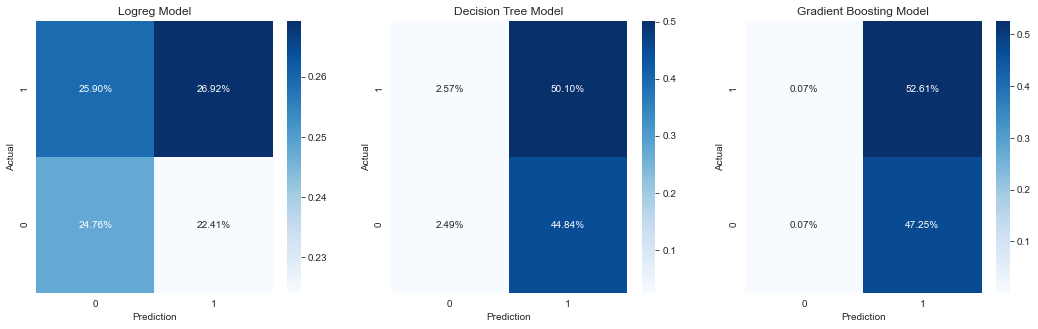

In [169]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

cm_logreg = logreg_report["model_performance"]["confusion_matrix"]
fx = sns.heatmap(cm_logreg/np.sum(cm_logreg), annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
fx.set(xlabel='Prediction', ylabel='Actual', title="Logreg Model")
fx.set_ylim([0,2])

cm_dt = dt_s2_model_report["model_performance"]["confusion_matrix"]
fx = sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, fmt='.2%', cmap='Blues', ax=ax[1])
fx.set(xlabel='Prediction', ylabel='Actual', title="Decision Tree Model")
fx.set_ylim([0,2])

cm_gb = gb_s2_model_report["model_performance"]["confusion_matrix"]
fx = sns.heatmap(cm_gb/np.sum(cm_gb), annot=True, fmt='.2%', cmap='Blues', ax=ax[2])
fx.set(xlabel='Prediction', ylabel='Actual', title="Gradient Boosting Model")
fx.set_ylim([0,2])

fig.show()

# Only using the most important features

In [456]:
features_logreg = list(ft_importance_logreg["feature"].head(n=20))
features_dt = [i[0] for i in feature_importances_dt[:10]]
features_gb = [i[0] for i in feature_importances_dg_gb[:20]]

I number of features used differes between the models: logreg seems to improve the more features are used, decision tree is best with a rather smaller number of features and the gradient boosting model doesn't improve by reducing the number of features. 

All models did however improve in terms of time to fit.

**Data preparation:** train & test split, feature selection and scaling of data.

In [457]:
split_date = "2019-10-01"
df_train = data.loc[data.index < split_date]
df_test = data.loc[data.index >= split_date]

target_col = "increasing_target"
scaler = MinMaxScaler()

# Logreg
X_train_logreg = df_train[features_logreg]
X_test_logreg = df_test[features_logreg]
X_train_logreg = scaler.fit_transform(X_train_logreg)
X_test_logreg = scaler.transform(X_test_logreg)

# Decision Tree
X_train_dt = df_train[features_dt]
X_test_dt = df_test[features_dt]
X_train_dt = scaler.fit_transform(X_train_dt)
X_test_dt = scaler.transform(X_test_dt)

# Gradient Boosting
X_train_gb = df_train[features_gb]
X_test_gb = df_test[features_gb]
X_train_gb = scaler.fit_transform(X_train_gb)
X_test_gb = scaler.transform(X_test_gb)

# target values are the same for all models
y_train = df_train[target_col]
y_test = df_test[target_col]


In [453]:
logreg_top8 = LogisticRegression(solver="newton-cg", penalty="l2", class_weight="balanced", max_iter=200)
logreg_top8.fit(X_train_logreg, y_train)

logreg_top8_y_pred = logreg_top8.predict(X_test_logreg)
logreg_top8_model_report = model_report(logreg_top8, logreg_top8_y_pred, y_test, print_out=True, fname="LOGREG_top8.json")

print("Difference (accuracy): " + str(logreg_top8_model_report["model_performance"]["accuracy"] - logreg_report["model_performance"]["accuracy"]))

Accuracy: 0.5219582387768298
Precision: 0.5490171049272402
Recall: 0.5176127953016499
F1-Score: 0.5328526385559335
Created .json file 'LOGREG_top8.json'
Difference (accuracy): 0.0051173117626599485


Accuracy of the logreg model did increase using less features.

In [454]:
dt_top8 = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.05, splitter="random")
dt_top8.fit(X_train_dt, y_train)

dt_top8_y_pred = dt_top8.predict(X_test_dt)
dt_top8_model_report = model_report(dt_top8, dt_top8_y_pred, y_test, print_out=True, fname="DT_top8.json")

print("Difference (accuracy): " + str(dt_top8_model_report["model_performance"]["accuracy"] - dt_s2_model_report["model_performance"]["accuracy"]))

Accuracy: 0.527549222206727
Precision: 0.5291224489795918
Recall: 0.9360716305826002
F1-Score: 0.6760831489875833
Created .json file 'DT_top8.json'
Difference (accuracy): 0.0016481357049583645


Accuracy of the Decision Tree Model did improve unsing only the most important features.

In [458]:
gb_top8 = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_top8.fit(X_train_gb, y_train)

gb_top8_y_pred = gb_top8.predict(X_test_gb)
gb_top8_model_report = model_report(gb_top8, gb_top8_y_pred, y_test, print_out=True, fname="GB_top8.json")

print("Difference (accuracy): " + str(gb_top8_model_report["model_performance"]["accuracy"] - gb_s2_model_report["model_performance"]["accuracy"]))

Accuracy: 0.5268139001229762
Precision: 0.5268018075194841
Recall: 0.9989409456873624
F1-Score: 0.6898199512168771
Created .json file 'GB_top8.json'
Difference (accuracy): 1.901695044181917e-05


Accuracy of the Gradient Boosting Model did not improve unsing only the most important features.

# Company specific models

In this section I reestimated a Decision Tree & Gradient Boosting model only using the data of a single company. I randomly chose 3 companies:
- AAPL: Apple Inc. - Technology (Consumer Electronics)
- RMD: ResMed Inc. - Healthcare (Medical Instruments & Supplies)
- DLR: Digital Realty Trust, Inc. - Real Estate (REIT—Specialty)

The company specific models were fitted using the optimal parameters from the GridSearch.

As a comparison benchmark, I use the best score of the gradient boosting model so far (using all features): accuracy = 0.5267948831725344

In [249]:
# Data preparation for company specific models

split_date = "2019-10-01"
df_train = data.loc[data.index < split_date]
df_test = data.loc[data.index >= split_date]
feature_cols = ["symbol"] + feature_cols

target_col = "increasing_target"
scaler = MinMaxScaler()
X_train = df_train[feature_cols]
X_test = df_test[feature_cols]

y_train = df_train[["symbol"] + [target_col]]
y_test = df_test[["symbol"] + [target_col]]

In [250]:
# Creating respective datasets only including data of the company:

# AAPL
X_train_AAPL = scaler.fit_transform(X_train[X_train["symbol"] == "AAPL"].drop("symbol", axis=1))
X_test_AAPL = scaler.transform(X_test[X_test["symbol"] == "AAPL"].drop("symbol", axis=1))

# RMD
X_train_RMD = scaler.fit_transform(X_train[X_train["symbol"] == "RMD"].drop("symbol", axis=1))
X_test_RMD = scaler.transform(X_test[X_test["symbol"] == "RMD"].drop("symbol", axis=1))

# DLR
X_train_DLR = scaler.fit_transform(X_train[X_train["symbol"] == "DLR"].drop("symbol", axis=1))
X_test_DLR = scaler.transform(X_test[X_test["symbol"] == "DLR"].drop("symbol", axis=1))

### AAPL

In [267]:
# AAPL
# Decision Tree
dt_AAPL = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.05, splitter="random")
dt_AAPL.fit(X_train_AAPL, y_train[y_train["symbol"] == "AAPL"].drop("symbol", axis = 1))
dt_AAPL_y_pred = dt_AAPL.predict(X_test_AAPL)
dt_AAPL_model_report = model_report(dt_AAPL, dt_AAPL_y_pred, y_test[y_test["symbol"] == "AAPL"].drop("symbol", axis = 1), print_out=True, fname="DT_AAPL.json")
print("_"*50)
# Gradient Boosting
gb_AAPL = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_AAPL.fit(X_train_AAPL, y_train[y_train["symbol"] == "AAPL"].drop("symbol", axis = 1))
gb_AAPL_y_pred = gb_AAPL.predict(X_test_AAPL)
gb_AAPL_model_report = model_report(gb_AAPL, gb_AAPL_y_pred, y_test[y_test["symbol"] == "AAPL"].drop("symbol", axis = 1), print_out=True, fname="GB_AAPL.json")

Accuracy: 0.5394736842105263
Precision: 0.5682819383259912
Recall: 0.7543859649122807
F1-Score: 0.6482412060301508
Created .json file 'DT_AAPL.json'
__________________________________________________
Accuracy: 0.5
Precision: 0.5605095541401274
Recall: 0.5146198830409356
F1-Score: 0.5365853658536586
Created .json file 'GB_AAPL.json'


For Apple the accuracy of decision tree did improve, the accuracy of the gradient boosting did decrease.

### RMD

In [265]:
# RMD
# Decision Tree
dt_RMD = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.05, splitter="random")
dt_RMD.fit(X_train_RMD, y_train[y_train["symbol"] == "RMD"].drop("symbol", axis = 1))
dt_RMD_y_pred = dt_RMD.predict(X_test_RMD)
dt_RMD_model_report = model_report(dt_RMD, dt_RMD_y_pred, y_test[y_test["symbol"] == "RMD"].drop("symbol", axis = 1), print_out=True, fname="DT_RMD.json")
print("_"*50)
# Gradient Boosting
gb_RMD = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_RMD.fit(X_train_RMD, y_train[y_train["symbol"] == "RMD"].drop("symbol", axis = 1))
gb_RMD_y_pred = gb_RMD.predict(X_test_RMD)
gb_RMD_model_report = model_report(gb_RMD, gb_RMD_y_pred, y_test[y_test["symbol"] == "RMD"].drop("symbol", axis = 1), print_out=True, fname="GB_RMD.json")

Accuracy: 0.5427631578947368
Precision: 0.569620253164557
Recall: 0.7848837209302325
F1-Score: 0.6601466992665037
Created .json file 'DT_RMD.json'
__________________________________________________
Accuracy: 0.5723684210526315
Precision: 0.5766423357664233
Recall: 0.9186046511627907
F1-Score: 0.7085201793721972
Created .json file 'GB_RMD.json'


For RMD both models perform better using company specific data: the acc. of the gradient boosting model did improve by almost 5 percantage points.

### DLR

In [266]:
# DLR
# Decision Tree
dt_DLR = DecisionTreeClassifier(max_depth=9, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.05, splitter="random")
dt_DLR.fit(X_train_DLR, y_train[y_train["symbol"] == "DLR"].drop("symbol", axis = 1))
dt_DLR_y_pred = dt_DLR.predict(X_test_DLR)
dt_DLR_model_report = model_report(dt_DLR, dt_DLR_y_pred, y_test[y_test["symbol"] == "DLR"].drop("symbol", axis = 1), print_out=True, fname="DT_DLR.json")
print("_"*50)
# Gradient Boosting
gb_DLR = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3)
gb_DLR.fit(X_train_DLR, y_train[y_train["symbol"] == "DLR"].drop("symbol", axis = 1))
gb_DLR_y_pred = gb_DLR.predict(X_test_DLR)
gb_DLR_model_report = model_report(gb_DLR, gb_DLR_y_pred, y_test[y_test["symbol"] == "DLR"].drop("symbol", axis = 1), print_out=True, fname="GB_DLR.json")

Accuracy: 0.5427631578947368
Precision: 0.5291666666666667
Recall: 0.8300653594771242
F1-Score: 0.6463104325699746
Created .json file 'DT_DLR.json'
__________________________________________________
Accuracy: 0.5164473684210527
Precision: 0.5108695652173914
Recall: 0.9215686274509803
F1-Score: 0.6573426573426574
Created .json file 'GB_DLR.json'


For DLR we can observe a slight improvment of accuracy of the decision tree model.

Overall it seems to be a good practice to train the models only on company specific data. One could go further here and calculate sector speficic models and evaluate the performance.

# Feature importance of company specific models

In the following section I have a closer look at the feature importances of the company specific models for Apple Inc.

In [395]:
from scipy.stats.stats import pointbiserialr

# Function that returns a sorted list of tuples containing the feature and its importance (in %); additionally the top n features are printed out
def print_fi(fi_obj, feature_cols, n=5):
    fi_sorted = sorted([(feature_cols[i], fi_obj[i]) for i in list(np.where(fi_obj > 0)[0])], key=lambda x: x[1], reverse=True)
    
    print(f"Top {n} features:")
    for i in fi_sorted[:n]:
        print("Feature importance of feature '" + str(i[0]) + "' = " + str(round(i[1]*100, 4)) + "%")

    return fi_sorted

In [399]:
fi_dt_AAPL = print_fi(dt_AAPL.feature_importances_, feature_cols, n=5)
print("_"*50)
fi_gb_AAPL = print_fi(gb_AAPL.feature_importances_, feature_cols, n=5)

print("_"*50)
print("Intersections in top 15: " + str([i for i in [i[0] for i in fi_gb_AAPL[:15]] if i in [j[0] for j in fi_dt_AAPL[:15]]]))

Top 5 features:
Feature importance of feature 'ADOSC_3_10' = 14.6144%
Feature importance of feature 'D_9_3' = 13.8652%
Feature importance of feature 'low' = 10.4679%
Feature importance of feature 'CFO_9' = 10.228%
Feature importance of feature 'CDL_PIERCING' = 8.3939%
__________________________________________________
Top 5 features:
Feature importance of feature 'NATR_14' = 10.9282%
Feature importance of feature 'vwap' = 7.2892%
Feature importance of feature 'CMO_14' = 6.8584%
Feature importance of feature 'AROONOSC_14' = 6.3824%
Feature importance of feature 'RVGIs_14_4' = 5.667%
__________________________________________________
Intersections in top 15: ['D_9_3', 'BBB_5_2.0']


The decision tree model and the gradient boosting model hardly seem to use the same features; among the top 15 features there are only 2 intersections. This is interesting because both models are tree-based models.

Now lets look at the top 3 features of the decision tree model (Note: this decision tree model did perform better than the gradient boosting model):

In [434]:
# Correlations of feature variables and target variable
for feat in [j[0] for j in fi_dt_AAPL[:10]]:
    print(f"increasing:{feat} = " + str(pointbiserialr(y_test[y_test["symbol"] == "AAPL"]["increasing_target"], X_test[X_test["symbol"] == "AAPL"][feat])[0]))

increasing:ADOSC_3_10 = -0.07722049007363817
increasing:D_9_3 = 0.04849531236382136
increasing:low = -0.050094370662875365
increasing:CFO_9 = -0.11685660417692878
increasing:CDL_PIERCING = 0.04364357804719858
increasing:CDL_SHOOTINGSTAR = -0.08804509063256204
increasing:BBB_5_2.0 = -0.07352354075104084
increasing:THERMOs_20_2_0.5 = -0.07402391962093907
increasing:BBP_5_2.0 = -0.06218293739876206
increasing:QS_10 = -0.04442053095219146


There seems to be no major correlations with the target vairiable, which may be one of the reasons why our models can not really predict stock movement.

<AxesSubplot:xlabel='low', ylabel='increasing_target'>

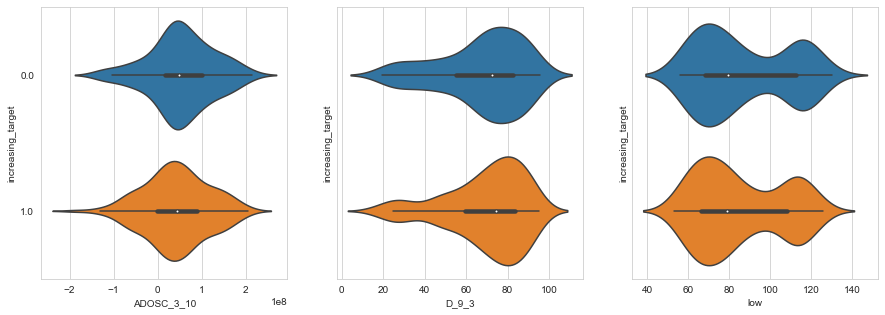

In [409]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.violinplot(X_test[X_test["symbol"] == "AAPL"]["ADOSC_3_10"], y_test[y_test["symbol"] == "AAPL"]["increasing_target"], ax=axes[0], orient="h")
sns.violinplot(X_test[X_test["symbol"] == "AAPL"]["D_9_3"], y_test[y_test["symbol"] == "AAPL"]["increasing_target"], ax=axes[1], orient="h")
sns.violinplot(X_test[X_test["symbol"] == "AAPL"]["low"], y_test[y_test["symbol"] == "AAPL"]["increasing_target"], ax=axes[2], orient="h")

Graphically it can also be seen that the two classes hardly differ (and thus no strong correlation is measurable). These violin-plots indicate the distribution of values for each class.